# 1. Data Preparation

## 1a. Create a database for Images

### Why a database for images?
Instead of treating images as loose files in folders, we store them in a database so they become a structured, queryable dataset. This allows fast filtering by time and metadata, consistent preprocessing, reproducible experiments, and direct integration with embedding and search pipelines. The database provides indexing, versioning, and efficient storage of both image content and derived representations, turning the image collection into a reliable data asset rather than an unmanaged directory of files.

> **Note**  
> Before running this notebook, ensure you have the variable and limits determined. See notebook <>


### Imports

In [1]:
import json
from datetime import datetime, timezone
from pathlib import Path

import lancedb
import pyarrow as pa
from helpers.ingest_images import ingest_images_to_table

### User Input

In [2]:
PROJECT_ROOT = Path.cwd().parent.parent

IMG_RAW_TBL_NAME = "era5_sample_images"

db_dir = PROJECT_ROOT / "data" / "lancedb" / "shared_source"

image_dir = PROJECT_ROOT / "data" / "processed_rgb"

# Connect to DB
db = lancedb.connect(str(db_dir))

### Metadata 

In [3]:
# 1. Define the metadata structure

metadata_dict = {
    # --- 1. CORE IDENTITY ---
    "dataset_name": "ERA5 Hurricane Training Data (RGB Composites)",
    "description": "Daily weather composites (MSL Anomaly, Wind, TCWV) for hurricane detection.",
    "author": "cherukuru",
    "generated_by_script": "e5_channels.ipynb",
    "created_at": datetime.now(timezone.utc).isoformat(),  # Dynamic Timestamp
    # --- 2. SOURCE PROVENANCE (Sorted by Importance) ---
    "source_metadata": {
        "data_source": "ECMWF: https://cds.climate.copernicus.eu, Copernicus Climate Data Store",
        "conventions": "CF-1.6",
        "conversion_logic": "CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4",
        "netcdf_version": "4.6.3",
        "conversion_platform": "Linux r8i6n32 4.12.14-94.41-default #1 SMP",
    },
    # --- 3. OUTPUT SPECIFICATIONS ---
    "image_specs": {
        "resolution": [224, 224],
        "thumb_resolution": [64, 64],
        "format": "JPEG",
        "quality": 90,
        "resampling": "Bilinear",
        "projection": "Plate Carrée (Equirectangular)",
    },
    # --- 4. SPATIAL & TEMPORAL BOUNDS ---
    "spatial_extent": {
        "lat_min": 15.0,
        "lat_max": 35.0,
        "lon_min": 260.0,
        "lon_max": 330.0,
        "notes": "North Atlantic / Caribbean (approx 100W to 30W)",
    },
    "temporal_extent": {
        "start": "2016-01-01",  # Updated Start
        "end": "2018-12-31",  # Updated End
        "interval": "Daily",
    },
    # --- 5. PHYSICS & CHANNELS ---
    "channels": {
        "red": {
            "variable": "MSL Pressure Anomaly",
            "range": [-20.0, 20.0],
            "unit": "hPa",
            "logic": "Inverted (Low Pressure = Bright Red)",
        },
        "green": {"variable": "10m Wind Speed (Daily Max)", "range": [0.0, 35.0], "unit": "m/s", "logic": "Linear"},
        "blue": {
            "variable": "Total Column Water Vapor (Daily Mean)",
            "range": [20.0, 70.0],
            "unit": "kg/m^2",
            "logic": "Square Root Scaled",
        },
    },
}

# 2. Serialize to JSON Bytes
arrow_metadata = {b"dataset_info": json.dumps(metadata_dict).encode("utf-8"), b"version": b"1.0"}

In [4]:
# Image table
schema = pa.schema(
    [
        pa.field("id", pa.string()),  # MD5 to generate a deterministic, content-based ID
        pa.field("filename", pa.string()),
        pa.field("dt", pa.timestamp("s")),
        pa.field("image_blob", pa.binary()),
        pa.field("thumb_blob", pa.binary()),
    ],
    metadata=arrow_metadata,
)

if IMG_RAW_TBL_NAME in db.table_names():
    db.drop_table(IMG_RAW_TBL_NAME)

table = db.create_table(IMG_RAW_TBL_NAME, schema=schema)

print(f"Table {IMG_RAW_TBL_NAME} created.")

Table era5_sample_images created.


In [5]:
# # Config Table (Global Metadata)

# config_data = [
#     {"key": "db_name",          "value": DB_NAME},
#     {"key": "created_at",       "value": datetime.now(UTC).strftime("%Y-%m-%dT%H:%M:%SZ")},
#     {"key": "author",           "value": "cherukuru"},
#     {"key": "project",          "value": "era5 data"},
#     {"key": "image_width",      "value": "224"},
#     {"key": "image_height",     "value": "224"},
#     {"key": "thumb_width",      "value": "64"},
#     {"key": "height",           "value": "64"},
#     {"key": "tbl_img_raw",      "value": IMG_RAW_TBL_NAME}
# ]

# # Create the config table
# # We use overwrite mode to ensure we don't have stale configs if re-running
# if METADATA_TBL_NAME in db.table_names():
#     db.drop_table(METADATA_TBL_NAME)

# # Note: We let LanceDB infer the simple schema (key: str, value: str) automatically
# # by passing the list of dicts directly.
# config_table = db.create_table(METADATA_TBL_NAME, data=config_data)
# print(f"Table {METADATA_TBL_NAME} created with global metadata.")

In [6]:
ingest_images_to_table(
    table, image_dir=image_dir, width=224, height=224, dt_format="%Y%m%d_rgb.jpeg", thumb_size=64, batch_size=256
)

Ingesting: 100%|██████████| 1095/1095 [02:26<00:00,  7.47it/s]

Done.
Images ingested: 1095


1095

In [7]:
table.schema

id: string
filename: string
dt: timestamp[s]
image_blob: binary
thumb_blob: binary
-- schema metadata --
dataset_info: '{"dataset_name": "ERA5 Hurricane Training Data (RGB Compos' + 1339
version: '1.0'

In [8]:
json.loads(table.schema.metadata[b"dataset_info"])

{'dataset_name': 'ERA5 Hurricane Training Data (RGB Composites)',
 'description': 'Daily weather composites (MSL Anomaly, Wind, TCWV) for hurricane detection.',
 'author': 'cherukuru',
 'generated_by_script': 'e5_channels.ipynb',
 'created_at': '2026-01-01T01:47:45.706976+00:00',
 'source_metadata': {'data_source': 'ECMWF: https://cds.climate.copernicus.eu, Copernicus Climate Data Store',
  'conventions': 'CF-1.6',
  'conversion_logic': 'CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4',
  'netcdf_version': '4.6.3',
  'conversion_platform': 'Linux r8i6n32 4.12.14-94.41-default #1 SMP'},
 'image_specs': {'resolution': [224, 224],
  'thumb_resolution': [64, 64],
  'format': 'JPEG',
  'quality': 90,
  'resampling': 'Bilinear',
  'projection': 'Plate Carrée (Equirectangular)'},
 'spatial_extent': {'lat_min': 15.0,
  'lat_max': 35.0,
  'lon_min': 260.0,
  'lon_max': 330.0,
  'notes': 'North Atlantic / Caribbean (approx 100W to 30W)'},
 'temporal_extent': {'start': '2016-01-01',
  'end'

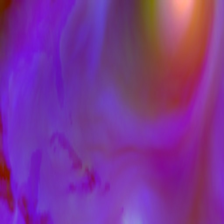

In [9]:
import io
import os

from PIL import Image

table.search().select(["id"]).limit(10).to_pandas()

row = table.search().limit(1000).to_pandas().iloc[999]
Image.open(io.BytesIO(row["image_blob"]))

In [10]:
def dir_size_bytes(path: Path) -> int:
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            total += (Path(root) / f).stat().st_size
    return total


table_path = db_dir / "image_raw.lance"
size_bytes = dir_size_bytes(table_path)

print(f"{size_bytes / 1024**2:.2f} MB")

0.00 MB
